# Susceptible-Infected-Recovered model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import multiprocessing as mp
import pickle
from datetime import date
import matplotlib.dates as mdates
import requests
import json
import os
from datetime import date
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp,odeint
import scipy.stats as st

For this compartmental model, we choose to fit the parameters on the data on confirmed cases provided by the Italian Protezione Civile deposited in this repository: https://github.com/pcm-dpc/COVID-19/raw/master/dati-json/

In [2]:
inf_col='Confirmed_cases'

url='https://github.com/pcm-dpc/COVID-19/raw/master/dati-json/dpc-covid19-ita-andamento-nazionale.json'
response = requests.get(url)
today=date.today()

In [3]:
datafilename='country'+today.strftime("%Y_%m_%d")+'.json'
#with open( 'data/PC/'+datafilename, 'w') as f:
#    json.dump(response.json(),f)

In [4]:
with open('data/PC/'+datafilename,'r') as f:
    data_file=json.load(f)
data=pd.DataFrame()
for p in data_file:
    data.loc[p['data'],'Hospitalized']=p['totale_ospedalizzati']
    data.loc[p['data'],'Confirmed_cases']=p['totale_positivi']
    data.loc[p['data'],'Deaths']=p['deceduti']
    data.loc[p['data'],'Recovered']=p['dimessi_guariti']
data.index=pd.to_datetime(data.index)
data['Removed']=data['Recovered']+data['Deaths']

#population=20000000.
population=60480000.
# Start of the study (can be modified as wanted)
#start = today-pd.DateOffset(days=20)
start=pd.to_datetime('2020-02-24 18:00:00')
end = data.index.max()
print('Data updated to: ',str(end))
days=(end-start).days+1
t = np.linspace(start.value, end.value, days)
t = pd.to_datetime(t)
tempo=np.linspace(1,days,days,dtype=int)


Data updated to:  2020-03-30 17:00:00


Some explorations of the timeserie of the confirmed cases.

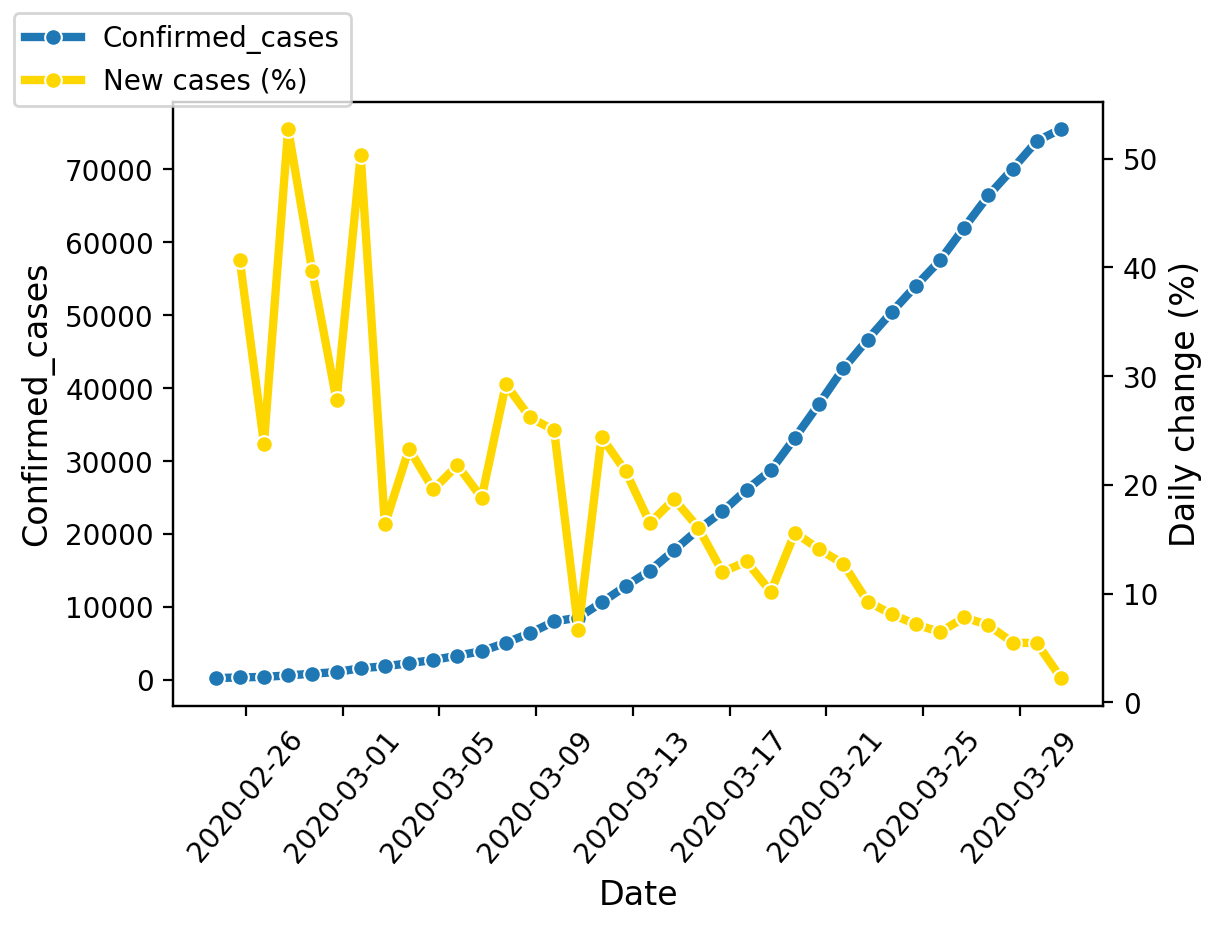

In [5]:
diff1=data[inf_col].pct_change()*100 #first derivative
#diff1=diff1.loc[start:,]
f,ax=plt.subplots(1,1,dpi=200)
sns.lineplot(x=data.index,y=inf_col,data=data,marker='o',
             label=inf_col,ax=ax)
plt.setp(ax.lines,linewidth=3)
ax2 = ax.twinx()
sns.lineplot(x=diff1.index,y=diff1,ax=ax2,label='New cases (%)',
             color='gold',marker='o')
#sns.lineplot(x=diff2.index,y=diff2,ax=ax2,label='Second derivative (%)',color='orange')
plt.setp(ax2.lines,linewidth=3)
ax2.set_ylabel('Daily change (%)',fontsize=12)
#ax.lines[1].set_linestyle("--")
ax.set_xlabel('Date',fontsize=12)
ax.set_ylabel(inf_col,fontsize=12)
#plt.yscale('log')
#ax.set_xlim(left=pd.to_datetime('2020-02-15'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=50,fontsize=10 )
plt.setp( ax.yaxis.get_majorticklabels(), fontsize=10 )
#plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
#plt.setp(ax.get_legend().get_title(), fontsize='18') # for legend title
ax.get_legend().remove()
ax2.get_legend().remove()
ax2.figure.legend(loc='upper left',fontsize=10)

The model we choose is a Susceptible-Infected-Recovered (SIR).  
We specify that R0 is not directly a parameter of the model, but you can derive it from other model parameters. Since R0 has the easy-to-say meaning of "secundary cases from a single infected person", it is very popular during this outbreak, and it is very useful to describe the behaviour of the epidemiological curves. (https://www.icts.res.in/sites/default/files/PuneR0talk.pdf)

In the next chunk, we initialize the parameter as we know from literature about COVID-19 (reference will be provided). Transmissivity $\beta$ and recovery rate $\mu$ are only starting points and their value will be extracted from the fit on the data.

In [6]:
days_inf=10
gamma=1/days_inf
R0=2.5
beta=gamma*R0
print('Initial parameters:\n beta={} gamma={}'.format(beta,gamma))

Initial parameters:
 beta=0.25 gamma=0.1


The number of confirmed case is known, but it is almost certain that the number of real infected people is much higher than the number of confirmed cases. For this reason, we decide to retrieve the value of infected people at the beginning of the study ($I_0$) from the data, using the number of confirmed cases on the first day only as initial guessing.

In [7]:
I0=data[data.index==start][inf_col].iloc[0]
R_i=data[data.index==start]['Removed'].iloc[0]
N=population
x0=[N-I0-R_i,I0,R_i]
print('\nInitial conditions:\n S={},I={},R={}'.format(x0[0],x0[1],x0[2]))


Initial conditions:
 S=60479771.0,I=221.0,R=8.0


We have set initial conditions (that will be fitted to). We also defined some constraints for the interval of $\beta=[0.0,1.0]$ and $I_0=[I_0,10*I_0]$.

In [8]:
def SIR_ode(t,x,beta,gamma):
        S,I,R=x
        dS=-beta*S*I/N
        dI=beta*S*I/N-gamma*I
        dR=gamma*I
        return [dS,dI,dR]
    
def SIRinteg(ti,beta,gamma):
    #I0,beta,mu=p
    #print(t)
    #x0=[N-I0,I0,R_i]    
    sol=solve_ivp(SIR_ode,[0,days],x0,args=(beta,gamma),t_eval=np.arange(0,days+1,1))
    lung=len(sol.y[0])
    #print(sol.y[1].reshape(1,25).shape)
    #print(np.concatenate((sol.y[1].reshape(1,25),sol.y[2].reshape(1,25)),axis=0).shape)
    #print(np.concatenate((sol.y[1].reshape(25,1),sol.y[2].reshape(25,1)),axis=1).shape)
    #print(sol.y[1][ti])
    #print(sol.y[1].shape)
    #return sol.y[1]
    #return np.concatenate((sol.y[1].reshape(1,25),sol.y[2].reshape(1,25)),axis=0)
    return np.concatenate((sol.y[1].reshape(lung,1),sol.y[2].reshape(lung,1)),axis=1).flatten()
    #return np.array([sol.y[1][t],sol.y[2][t]])
    
popt, pcov = curve_fit(SIRinteg, tempo, 
                       np.array(data.loc[start:,[inf_col,'Removed']].values).flatten(),
                       p0=[beta,gamma])
#I0=popt[0]
beta=popt[0]
gamma=popt[1]
R0=beta/gamma
#print('\nFitted parameters:\nI0= ',I0)
print('beta:',beta,' , gamma:',gamma)
print('R0:',R0,' , days_ill: {}'.format(1/gamma))

beta: 0.2313653676558001  , gamma: 0.05578095210002432
R0: 4.147748630050709  , days_ill: 17.927266608982173


In [9]:
#x0=[N-I0-R_i,I0,R_i]
integ=solve_ivp(SIR_ode,[0,days],x0,args=(beta,gamma),t_eval=tempo)
res=pd.DataFrame()
res['Susceptible']=integ.y[0]
res['Infected']=integ.y[1]
res['Removed']=integ.y[2]
res['Step']=tempo
res['Day']=t

[None, None]

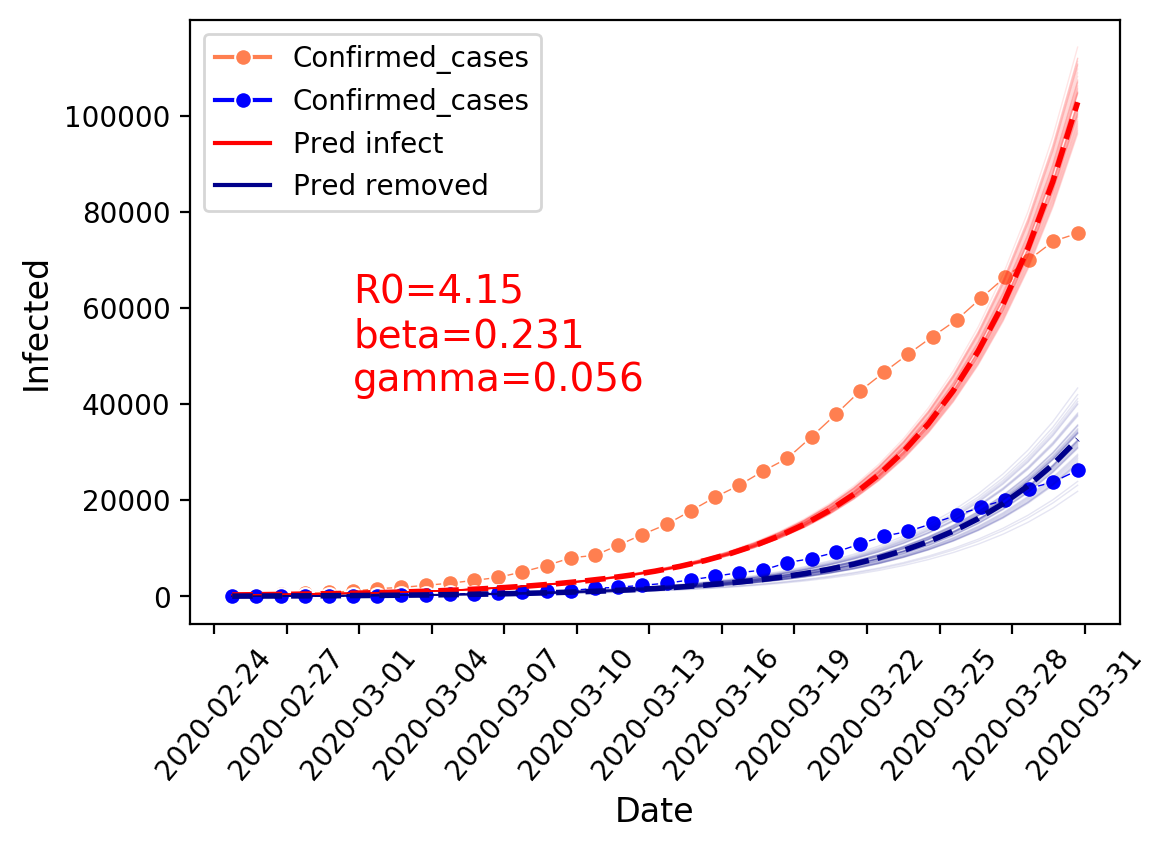

In [11]:
f,ax=plt.subplots(1,1,dpi=200)
sns.lineplot(x=data.index,y=inf_col,data=data,marker='o',ax=ax,
             label=inf_col,color='coral')
sns.lineplot(x=data.index,y='Removed',data=data,marker='o',ax=ax,
             label=inf_col,color='blue')

def phi(d, precision=30): 
    x = 2.00
    for i in range(precision): 
        x = pow(1+x,1/(d+1)) 
    return x

def gaussian_icdf(q):
    return st.norm.isf(q)

def identity(x):
    return x

def a_generate(ndim, Npoints, *, seed=721, mapper=identity):
    # get the base for the dimension
    g = phi(ndim) 
    # this is the inizialization constant for the array
    alpha = ((1/g)**np.arange(1, ndim+1))%1  
    # reshaping to allow broadcasting
    alpha = alpha.reshape(1, -1) 
    # just the count of the sequence
    base = np.arange(Npoints).reshape(-1, 1) 
    # perform the actual calculation
    z = seed + alpha*base 
    # tale only the decimal part
    z = z % 1
    # return a mapped version to some distribution
    return mapper(z)

class mapper_multivariate_normal:
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov
        # we have to use the cholesky decomposition to generate the samples
        self.L = np.linalg.cholesky(cov)
        
    def __call__(self, quantiles):
        values_standard = st.norm.isf(quantiles)
        values =  self.L @ values_standard.reshape(len(self.L), -1)
        values = values + self.mean.reshape(len(self.L), -1)
        return values.T
    
mapper = mapper_multivariate_normal(mean=popt, cov=pcov)
p_seq = a_generate(2, 50, mapper=mapper)
#x_base = np.linspace(0, 10, 51)

for params in p_seq:
    if sum(params)<np.inf:
        y_hat = solve_ivp(SIR_ode,[0,days],x0,args=(params),t_eval=tempo)
        sns.lineplot(x=res.Day,y=y_hat.y[1],ax=ax,
                     #label='beta={:1.2f} mu={:1.2f}'.format(params[0],params[1]),
                     color='red',alpha=0.1)
        sns.lineplot(x=res.Day,y=y_hat.y[2],ax=ax,
                     #label='beta={:1.2f} mu={:1.2f}'.format(params[0],params[1]),
                     color='darkblue',alpha=0.1)
    
sns.lineplot(x='Day',y='Infected',data=res,ax=ax,label='Pred infect',color='r')
sns.lineplot(x='Day',y='Removed',data=res,ax=ax,label='Pred removed',color='darkblue')
plt.setp(ax.lines,linewidth=0.5)
plt.setp(ax.lines[-1],linewidth=2)
plt.setp(ax.lines[-2],linewidth=2)
ax.lines[-1].set_linestyle("--")
ax.lines[-2].set_linestyle("--")
ax.set_xlabel('Date',fontsize=12)
ax.set_ylabel('Infected',fontsize=12)
plt.annotate('R0={:1.2f}\nbeta={:1.3f}\ngamma={:1.3f}'.format(R0,beta,gamma),
             xy=(mdates.date2num(data.index[5]), data[inf_col][-10]),
             fontsize=14,color='r')
#plt.yscale('log')
#ax.set_xlim(pd.to_datetime('2020-02-15'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=50,fontsize=10 )
plt.setp( ax.yaxis.get_majorticklabels(), fontsize=10 )
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title

### Long time behaviour

[None, None]

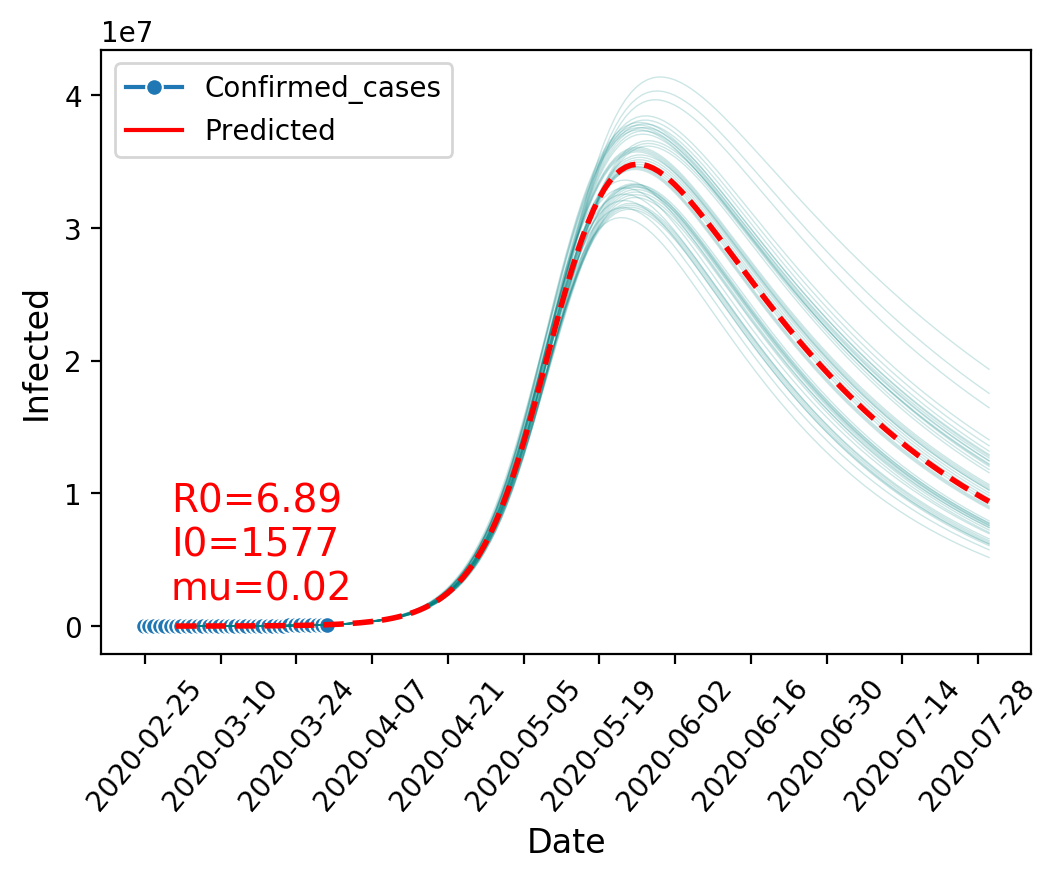

In [18]:
end = pd.Timestamp('2020-07-30')
days=(end-start).days+1
t_long = np.linspace(start.value, end.value, days)
t_long = pd.to_datetime(t_long)
tempo_long=np.linspace(1,days,days)

integ=solve_ivp(SIR_ode,[0,days],x0,args=(beta,mu),t_eval=tempo_long)
res_long=pd.DataFrame()
res_long['Susceptible']=integ.y[0]
res_long['Infected']=integ.y[1]
res_long['Recovered']=integ.y[2]
res_long['Step']=tempo_long
res_long['Day']=t_long

f,ax=plt.subplots(1,1,dpi=200)
sns.lineplot(x=data.index,y=inf_col,data=data,marker='o',ax=ax,
             label=inf_col)

mapper = mapper_multivariate_normal(mean=popt, cov=pcov)
p_seq = a_generate(2, 50, mapper=mapper)
#x_base = np.linspace(0, 10, 51)

for params in p_seq:
    if sum(params)<np.inf:
        y_hat = solve_ivp(SIR_ode,[0,days],x0,args=(params),t_eval=tempo_long)
        sns.lineplot(x=res_long.Day,y=y_hat.y[1],ax=ax,
                     #label='beta={:1.2f} mu={:1.2f}'.format(params[0],params[1]),
                     color='teal',alpha=0.2)
    
sns.lineplot(x='Day',y='Infected',data=res_long,ax=ax,label='Predicted',color='r')
plt.setp(ax.lines,linewidth=0.5)
plt.setp(ax.lines[-1],linewidth=2)
ax.lines[-1].set_linestyle("--")
ax.set_xlabel('Date',fontsize=12)
ax.set_ylabel('Infected',fontsize=12)
plt.annotate('R0={:1.2f}\nI0={}\nmu={:1.2f}'.format(R0,int(I0),mu),
             xy=(mdates.date2num(data.index[5]), 2000000),
             fontsize=14,color='r')
#plt.yscale('log')
#ax.set_xlim(pd.to_datetime('2020-02-15'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=50,fontsize=10 )
plt.setp( ax.yaxis.get_majorticklabels(), fontsize=10 )
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title

In [20]:
#Number of total infected
TI=int(res_long['Infected'].iloc[-1]+res_long['Recovered'].iloc[-1])
print('Total infected from {} to {}: {}\n equal to {:2.2f} % of the population of Italy'.format(
        start,end,TI,100*TI/population))

Total infected from 2020-03-01 18:00:00 to 2020-07-30 00:00:00: 60299169
 equal to 99.70 % of the population of Italy
